The purpose of this notebook is to create a neural implementation of a dot product. This is a very simple operation, but it is the basis of many more complex operations.


In [45]:
import numpy as np 
import matplotlib.pyplot as plt



In [2]:
N=5

In [3]:
x = np.random.random(N)
y=np.random.random(N)
z=np.dot(x,y)
print(z)


0.629726781140944


First, we can try to do simple multiplication using coincidence of spiking neurons

In [4]:
x_prob,y_prob = np.random.random(),np.random.random() # spike probability of each neuron

K = 100000
xs = np.random.random(K) < x_prob # spike trains of neuron x
ys = np.random.random(K) < y_prob # spike trains of neuron y
zs = xs & ys
approx = np.mean(zs)
print("Exact product: ", x_prob * y_prob)
print("Approximate product: ", approx)

Exact product:  0.18284014341262536
Approximate product:  0.18372


Next we can try doing a scaled dot product using the same method. We will scale the probabilities first, so that the spike probability of each individual component is low, thus lowering the probability of a collision when we OR all of the streams together.

In [158]:
N=256
# M=100
K=20000
# x_prob,y_prob = np.random.random(N)/10,np.random.random(N)/10 # spike probability of each neuron
x_prob,y_prob = np.abs(np.random.normal(0, 1./10, N)),np.abs(np.random.normal(0, 1./10, N)) # spike probability of each neuron

xs = np.random.random((K,N)) < x_prob   # K x N matrix of boolean spikes for neuron x
ys = np.random.random((K,N)) < y_prob   # K x N matrix of boolean spikes for neuron y
mask = np.random.random((K,N)) < 1/np.sqrt(N) # K x N matrix of boolean mask

zs = xs & ys & mask # K vector of boolean ANDs, then averaged over neurons
output_spike_train = np.any(zs, axis=1) # K vector of boolean ORs
approx = np.mean(output_spike_train) # average over K trials
exact = np.prod(np.dot(x_prob,y_prob)/np.sqrt(N))
percent_error = np.abs(approx - exact) / exact * 100
angle = np.arccos(np.dot(x_prob,y_prob)/np.sqrt(np.dot(x_prob,x_prob)*np.dot(y_prob,y_prob)))

print("Exact product: ", round(exact, 5))
print("Approximate product: ", round(approx, 5))
print("Percent error: ", round(percent_error, 5), "%")
print("Angle: ", round(angle, 5), " radians")


Exact product:  0.09156
Approximate product:  0.08915
Percent error:  2.63458 %
Angle:  0.83272  radians


Next, we try to do the same thing using something like a LIF neuron

In [138]:
class LIF():
    def __init__(self, tau, dt, Vth, Vreset, Vinit,rfp=0.0):
        self.tau = tau
        self.dt = dt
        self.Vth = Vth
        self.Vreset = Vreset
        self.Vinit = Vinit
        self.V = Vinit
        self.t = 0
        self.spikes = []
    def update(self, I):
        self.t += self.dt
        # print(self.t)
        self.V += (-self.V+I)*(1-np.exp(-self.dt/self.tau)) # This is the new version with tau<<dt
        # self.V += (-self.V+I)*self.dt/self.tau # This one was working with dt=tau
        if self.V > self.Vth:
            # print("spiked")
            self.spikes.append(self.t)
            self.V = self.Vreset
        return self.V
    def mean_activity(self):
        # return len(self.spikes)/self.t
        return len(self.spikes)/(self.t/self.dt)
    def reset(self):
        self.V = self.Vinit
        self.t = 0
        self.spikes = []

class LIFNeuron:
    def __init__(self, threshold=1.0, decay=0.1, potential_reset=0.0):
        self.threshold = threshold  # Firing threshold
        self.decay = decay  # Decay factor for potential
        self.potential = 0.0  # Initial potential
        self.potential_reset = potential_reset  # Reset value for potential

    def receive_spike(self):
        self.potential += 1  # Increment potential for each spike

    def time_step(self):
        if self.potential >= self.threshold:
            self.potential = self.potential_reset  # Reset potential after firing
            return True  # Neuron fires
        self.potential -= self.decay * self.potential  # Decay potential
        return False  # Neuron does not fire
    


This one basically implements an identity function...

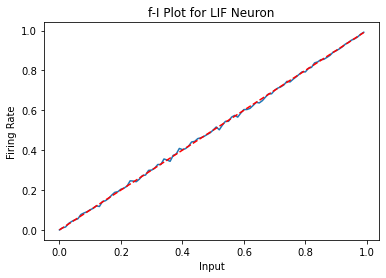

In [115]:
dt = 0.1
tau = 1
Vth = 0.001
Vreset = 0
Vinit = 0
lif = LIF(tau, dt, Vth, Vreset, Vinit)

K = int(500/dt)
T = range(K)
firing_rates = []
inputs = np.arange(0, 1, 0.01)


for I in inputs:
    # T = range(K)
    for t in range(K):
        spiking_input = 1.*(np.random.random()<I)
        lif.update(spiking_input)
        # print(lif.V)
        # print(spiking_input)
    firing_rates.append(lif.mean_activity())
    # print(lif.spikes)
    lif.reset()

plt.plot(inputs, firing_rates)
plt.plot(inputs, inputs, 'r--')  # Add identity plot
plt.xlabel('Input')
plt.ylabel('Firing Rate')
plt.title('f-I Plot for LIF Neuron')
plt.show()



# K=1000
# T=range(K)
# for t in T:
#     xs = 1.*(np.random.random()<x[0])
#     ys = 1.*(np.random.random()<y[0])
#     lif.update(xs and ys)
# print(lif.mean_activity())


Now, let's try to make one that multiplies inputs

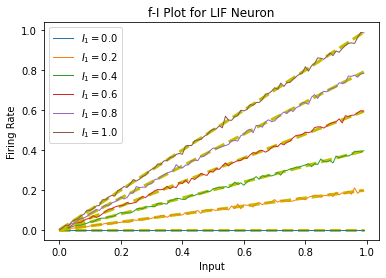

In [139]:
# dt = 0.1 #0.01
# tau = dt #dt/10 Looks cool! 
dt = 0.8 #0.01
tau = 1.0 #dt/10 Looks cool! 
Vth = 1.0
Vreset = 0
Vinit = 0
lif = LIF(tau, dt, Vth, Vreset, Vinit)

K = int(5000/dt)
T = range(K)
firing_rates = []
inputs = np.arange(0, 1.0, 0.01)

for I1 in [0.0,0.2,0.4,0.6,0.8,1.0]:
    firing_rates = []
    for I2 in inputs:
        # T = range(K)
        for t in range(K):
            spiking_input = 1.*(np.random.random()<I1*dt)+1.*(np.random.random()<I2*dt)
            lif.update(spiking_input)
        firing_rates.append(lif.mean_activity())
        lif.reset()

    plt.plot(inputs, I1*inputs, 'y--', linewidth=3)  # Add identity plot
    plt.plot(inputs, np.array(firing_rates)/dt**2,linewidth=1,label=r"$I_1=$"+str(I1))
plt.xlabel('Input')
plt.ylabel('Firing Rate')
plt.title('f-I Plot for LIF Neuron')
plt.legend()
plt.show()

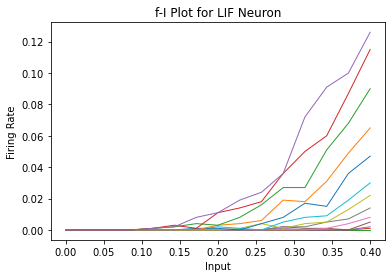

In [157]:
dt = 0.1 #0.01
tau = 1.0 #dt/10 Looks cool! 
Vth = 1.0
Vreset = 0
Vinit = 0
lif = LIF(tau, dt, Vth, Vreset, Vinit)

K = int(1000/dt)
T = range(K)
firing_rates = []
# inputs = np.arange(0, 1.0, 0.01)
inputs = np.linspace(0.0, 0.4, 15)
wait1 = 0
wait2 = 0
for I1 in inputs:
    firing_rates = []
    for I2 in inputs:
        # T = range(K)
        for t in range(K):
            spike1 = np.random.random()<I1 and wait1 == 0
            spike2 = np.random.random()<I2 and wait1 == 0 
            if spike1:
                wait1 = 1
            if spike2:
                wait2 = 1
            if wait1 > 0:
                wait1 -= 1
            if wait2 > 0:
                wait2 -= 1
            spiking_input = spike1+spike2
            lif.update(spiking_input)
        firing_rates.append(lif.mean_activity())
        lif.reset()

    # plt.plot(inputs, I1*inputs, 'y--', linewidth=3)  # Add identity plot
    plt.plot(inputs, np.array(firing_rates)/dt,linewidth=1,label=r"$I_1=$"+str(I1))
plt.xlabel('Input')
plt.ylabel('Firing Rate')
plt.title('f-I Plot for LIF Neuron')
# plt.legend()
plt.show()

What if we focus on low firing rates

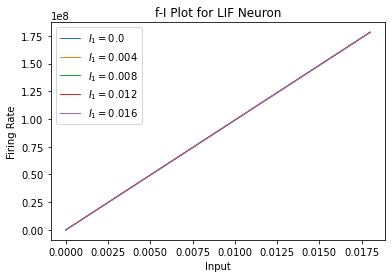

In [131]:
dt = 0.1 #0.01
tau = 5*dt #2*dt 
Vth = 1.0 #1.0
Vreset = 0
Vinit = 0
lif = LIF(tau, dt, Vth, Vreset, Vinit)

K = int(50000/dt)
T = range(K)
firing_rates = []
max_fr=0.02
inputs = np.arange(0, max_fr, max_fr/10)

for I1 in np.arange(0,max_fr,max_fr/5):
    firing_rates = []
    for I2 in inputs:
        for t in range(K):
            spiking_input = 1.*(np.random.random()<I1)+1.*(np.random.random()<I2)
            lif.update(spiking_input)
        firing_rates.append(lif.mean_activity())
        lif.reset()

    # plt.plot(inputs, I1*inputs, 'y--', linewidth=3)  # Add identity plot
    # plt.plot(inputs, firing_rates,linewidth=1,label=r"$I_1=$"+str(I1))
    plt.plot(inputs,I*inputs/(np.array(firing_rates)+1e-10),linewidth=1,label=r"$I_1=$"+str(I1))
plt.xlabel('Input')
plt.ylabel('Firing Rate')
plt.title('f-I Plot for LIF Neuron')
plt.legend()
plt.show()

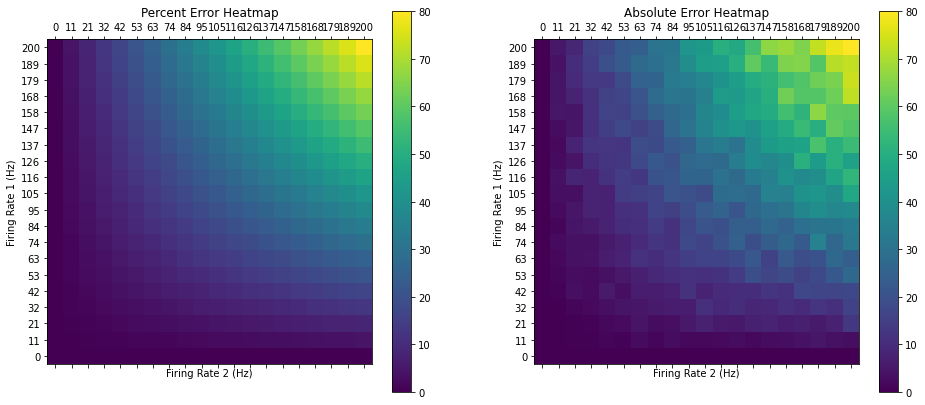

In [130]:
# Define LIF neuron
dt = 0.001 
tau = 0.002
Vth = 1.0
Vreset = 0
Vinit = 0
lif = LIF(tau, dt, Vth, Vreset, Vinit)

# Parameters
total_time = 10000  # Total time in ms

# Firing rates from 0 to 100 Hz
firing_rates = np.linspace(0, 200, 20)

# percent_error_matrix, absolute_error_matrix = errorHeatmap(firing_rates,total_time,lif)
exact_product_matrix,approx_product_matrix = getHeatmap(firing_rates,total_time,lif)

# alpha = np.sum(approx_product_matrix*exact_product_matrix)/np.sum(approx_product_matrix**2)
# alpha = np.sum(approx_product_matrix/exact_product_matrix)/np.sum(approx_product_matrix**2/exact_product_matrix**2)
alpha=np.max(exact_product_matrix)/np.max(approx_product_matrix)

# plotHeatmap(exact_product_matrix,approx_product_matrix)
plotHeatmap(exact_product_matrix,alpha*approx_product_matrix)
# plotHeatmap(exact_product_matrix,np.abs(approx_product_matrix*alpha-exact_product_matrix)/exact_product_matrix*100)
